 # STL-10 UNSUPERVISED LEARNING


## Install required packages


In [2]:
!pip install -q numpy matplotlib seaborn scikit-learn scikit-image pandas umap-learn kagglehub


## Import all libraries

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
from PIL import Image
import pandas as pd
import os
import warnings

In [4]:
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## DOWNLOAD STL-10 DATASET FROM KAGGLE

In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/stl10")
print(f"Path to dataset files: {path}")

# Find the unlabeled images
unlabeled_path = os.path.join(path, "unlabeled_X.bin")
print(f"Unlabeled data file: {unlabeled_path}")

Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/stl10/versions/3
Unlabeled data file: /root/.cache/kagglehub/datasets/jessicali9530/stl10/versions/3/unlabeled_X.bin


## LOAD STL-10 UNLABELED IMAGES

In [14]:
# STL-10 binary format: 96x96x3 images stored as uint8
def read_stl10_binary(file_path):
    """Read STL-10 binary file"""
    with open(file_path, 'rb') as f:
        # Read all data
        data = np.fromfile(f, dtype=np.uint8)
        # Reshape to (num_images, 3, 96, 96)
        images = data.reshape(-1, 3, 96, 96)
        # Transpose to (num_images, 96, 96, 3)
        images = np.transpose(images, (0, 2, 3, 1))
    return images

# Load unlabeled images
all_images = read_stl10_binary(unlabeled_path)
print(f"Total unlabeled images loaded: {len(all_images)}")
print(f"Image shape: {all_images[0].shape}")

# Sample for computational efficiency
np.random.seed(42)
n_samples = 15000  # Adjust based on your needs
sample_indices = np.random.choice(len(all_images), n_samples, replace=False)
images = all_images[sample_indices]

print(f"\nSampling {n_samples} images for analysis...")
print(f"Final dataset shape: {images.shape}")


FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/jessicali9530/stl10/versions/3/unlabeled_X.bin'

In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/stl10")
print(f"Path to dataset files: {path}")

# Find the unlabeled images
unlabeled_path = os.path.join(path, "unlabeled_X.bin")
print(f"Unlabeled data file: {unlabeled_path}")

Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/stl10/versions/3
Unlabeled data file: /root/.cache/kagglehub/datasets/jessicali9530/stl10/versions/3/unlabeled_X.bin


In [16]:
# The original attempt to load the STL-10 dataset from a binary file
# encountered a FileNotFoundError. To resolve this, we use torchvision.
# Install torchvision if not already installed (required for STL10 dataset)
!pip install -q torchvision

import numpy as np
from torchvision.datasets import STL10

print("Loading STL-10 unlabeled dataset using torchvision...")
dataset = STL10(root='./data', split='unlabeled', download=True)

# Sample for computational efficiency
np.random.seed(42)
n_samples = 15000
if n_samples > len(dataset):
    n_samples = len(dataset)
    print(f"Adjusted n_samples to {n_samples} as it exceeded dataset size.")

sample_indices = np.random.choice(len(dataset), n_samples, replace=False)

print(f"\nSampling {n_samples} images from {len(dataset)} total unlabeled images...")

# Convert images from PIL format to NumPy arrays
images = []
for i, idx in enumerate(sample_indices):
    img, _ = dataset[idx]
    images.append(np.array(img))
    if (i + 1) % 1000 == 0:
        print(f"  Loaded {i+1}/{n_samples} images...")

images = np.array(images)
print(f"\n✅ Dataset loaded successfully!")
print(f"Total unlabeled images loaded: {len(images)}")
print(f"Image shape: {images[0].shape}")

Loading STL-10 unlabeled dataset using torchvision...


100%|██████████| 2.64G/2.64G [01:45<00:00, 25.1MB/s]



Sampling 15000 images from 100000 total unlabeled images...
  Loaded 1000/15000 images...
  Loaded 2000/15000 images...
  Loaded 3000/15000 images...
  Loaded 4000/15000 images...
  Loaded 5000/15000 images...
  Loaded 6000/15000 images...
  Loaded 7000/15000 images...
  Loaded 8000/15000 images...
  Loaded 9000/15000 images...
  Loaded 10000/15000 images...
  Loaded 11000/15000 images...
  Loaded 12000/15000 images...
  Loaded 13000/15000 images...
  Loaded 14000/15000 images...
  Loaded 15000/15000 images...

✅ Dataset loaded successfully!
Total unlabeled images loaded: 15000
Image shape: (96, 96, 3)


In [18]:
print(f"Final sampled dataset shape: {images.shape}")
print(f"Image dimensions: {images[0].shape}")

Final sampled dataset shape: (15000, 96, 96, 3)
Image dimensions: (96, 96, 3)


## EXPLORATORY DATA ANALYSIS

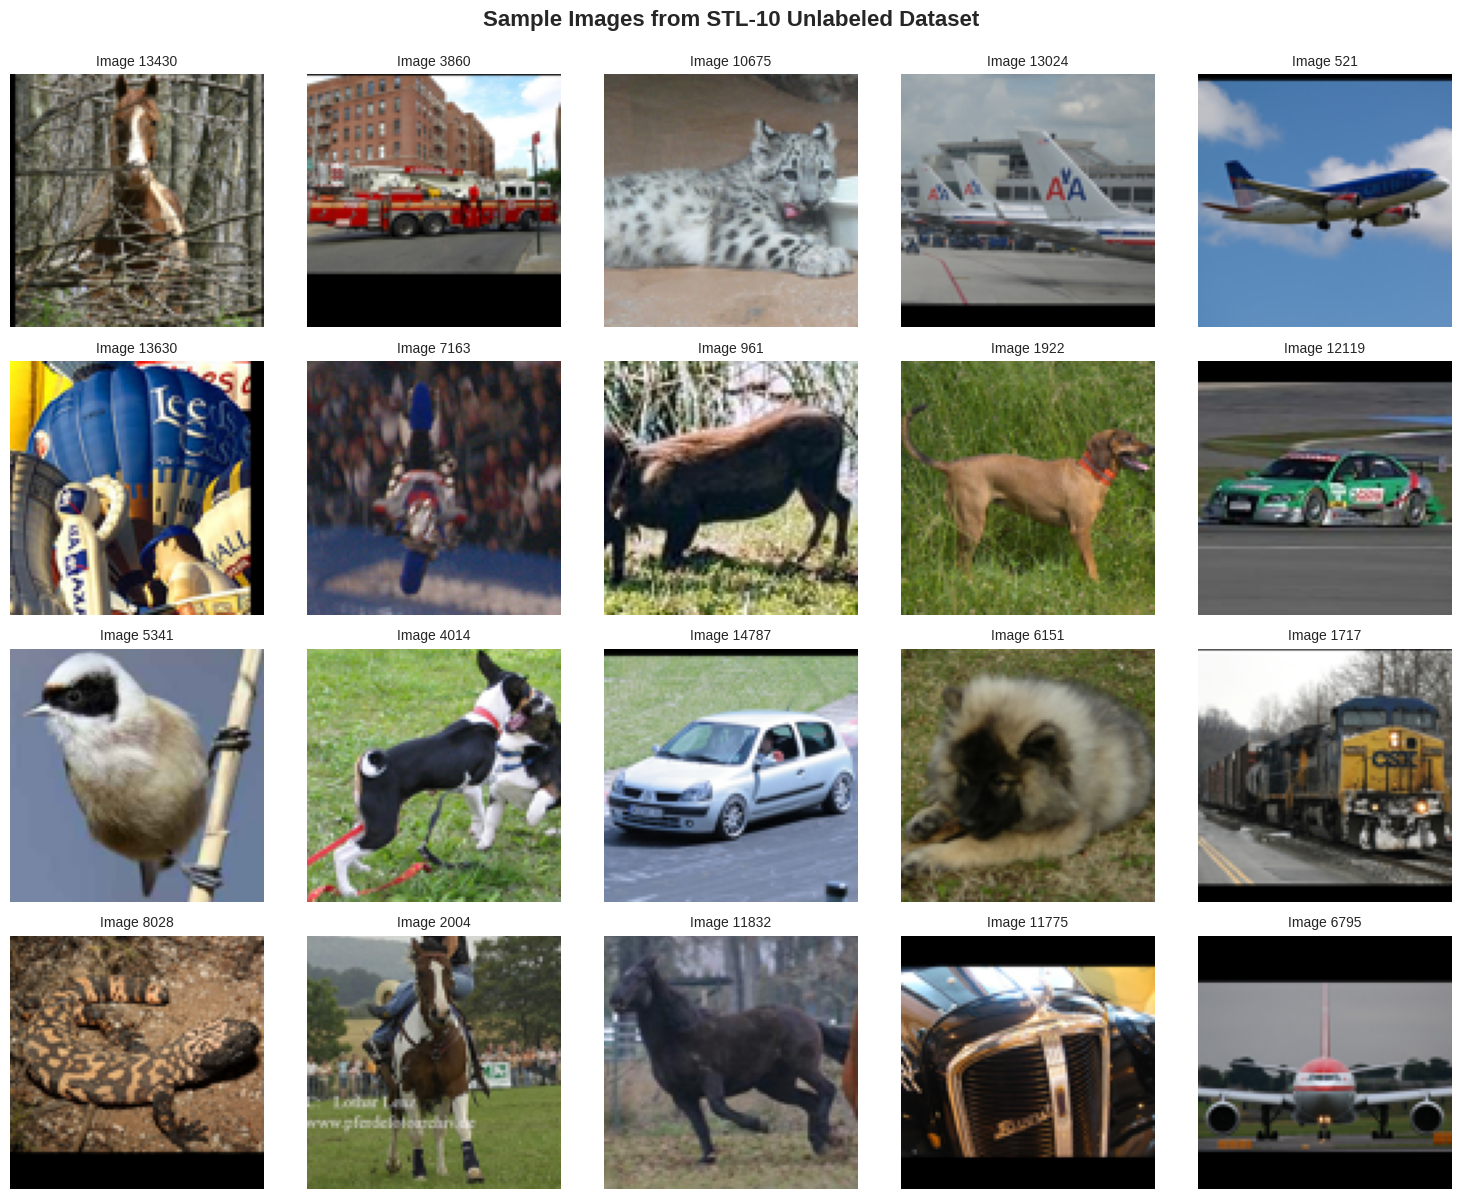

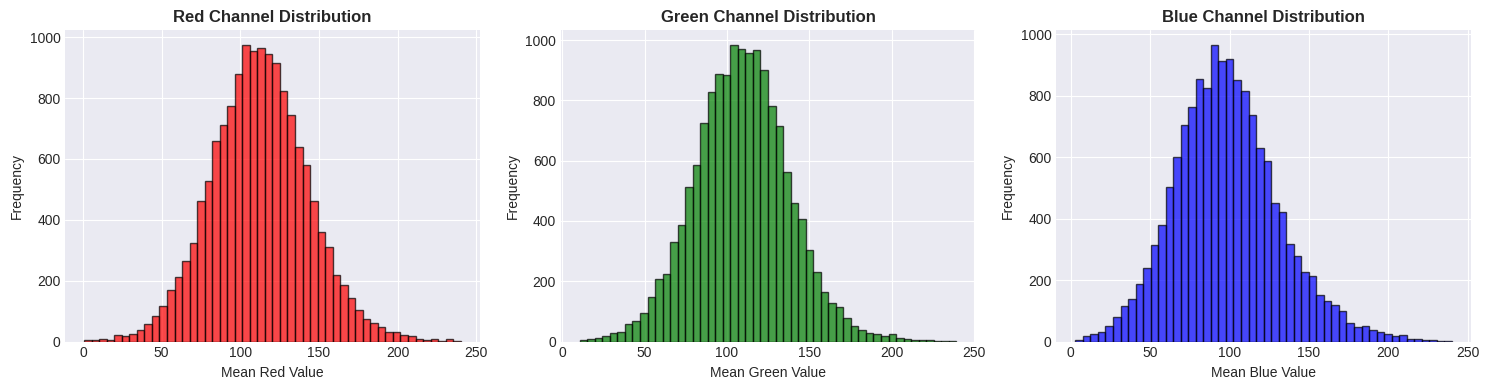

In [20]:
# Display sample images
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.ravel()
random_indices = np.random.choice(len(images), 20, replace=False)

for i, idx in enumerate(random_indices):
    axes[i].imshow(images[idx])
    axes[i].axis('off')
    axes[i].set_title(f'Image {idx}', fontsize=10)

plt.suptitle('Sample Images from STL-10 Unlabeled Dataset', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('01_sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze color distribution
mean_r = images[:, :, :, 0].mean(axis=(1, 2))
mean_g = images[:, :, :, 1].mean(axis=(1, 2))
mean_b = images[:, :, :, 2].mean(axis=(1, 2))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(mean_r, bins=50, color='red', alpha=0.7, edgecolor='black')
axes[0].set_title('Red Channel Distribution', fontweight='bold')
axes[0].set_xlabel('Mean Red Value')
axes[0].set_ylabel('Frequency')

axes[1].hist(mean_g, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Green Channel Distribution', fontweight='bold')
axes[1].set_xlabel('Mean Green Value')
axes[1].set_ylabel('Frequency')

axes[2].hist(mean_b, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[2].set_title('Blue Channel Distribution', fontweight='bold')
axes[2].set_xlabel('Mean Blue Value')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('02_color_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

##  FEATURE EXTRACTION

In [21]:
# 4.1 Color Histogram Features
print("\nExtracting color histogram features...")
color_features = []
for i, img in enumerate(images):
    hist_r = np.histogram(img[:,:,0], bins=32, range=(0,256))[0]
    hist_g = np.histogram(img[:,:,1], bins=32, range=(0,256))[0]
    hist_b = np.histogram(img[:,:,2], bins=32, range=(0,256))[0]
    hist_combined = np.concatenate([hist_r, hist_g, hist_b])
    hist_normalized = hist_combined / (hist_combined.sum() + 1e-6)
    color_features.append(hist_normalized)
    if (i+1) % 1000 == 0:
        print(f"  Processed {i+1}/{len(images)} images...")

color_features = np.array(color_features)
print(f"✅ Color histogram features: {color_features.shape}")

# 4.2 HOG Features
print("\nExtracting HOG features...")
hog_features = []
for i, img in enumerate(images):
    gray = rgb2gray(img)
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False, feature_vector=True)
    hog_features.append(hog_feat)
    if (i+1) % 1000 == 0:
        print(f"  Processed {i+1}/{len(images)} images...")

hog_features = np.array(hog_features)
print(f"✅ HOG features: {hog_features.shape}")

# 4.3 Statistical Features
print("\nExtracting statistical features...")
stat_features = []
for i, img in enumerate(images):
    feats = []
    for channel in range(3):
        ch = img[:, :, channel]
        feats.extend([ch.mean(), ch.std(), ch.min(), ch.max(),
                     np.median(ch), np.percentile(ch, 25), np.percentile(ch, 75)])
    feats.append(img.mean())
    feats.append(img.std())
    stat_features.append(feats)
    if (i+1) % 1000 == 0:
        print(f"  Processed {i+1}/{len(images)} images...")

stat_features = np.array(stat_features)
print(f"✅ Statistical features: {stat_features.shape}")

# 4.4 Texture Features (LBP)
print("\nExtracting texture features (LBP)...")
texture_features = []
for i, img in enumerate(images):
    gray = rgb2gray(img)
    gray = (gray * 255).astype(np.uint8)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist / (hist.sum() + 1e-6)
    texture_features.append(hist)
    if (i+1) % 1000 == 0:
        print(f"  Processed {i+1}/{len(images)} images...")

max_len = max(len(f) for f in texture_features)
texture_features = np.array([np.pad(f, (0, max_len - len(f))) for f in texture_features])
print(f"✅ Texture features: {texture_features.shape}")

# 4.5 Combine all features
print("\nCombining all features...")
all_features = np.hstack([color_features, hog_features, stat_features, texture_features])
print(f"✅ Combined features shape: {all_features.shape}")
print(f"Total feature dimensions: {all_features.shape[1]}")


Extracting color histogram features...
  Processed 1000/15000 images...
  Processed 2000/15000 images...
  Processed 3000/15000 images...
  Processed 4000/15000 images...
  Processed 5000/15000 images...
  Processed 6000/15000 images...
  Processed 7000/15000 images...
  Processed 8000/15000 images...
  Processed 9000/15000 images...
  Processed 10000/15000 images...
  Processed 11000/15000 images...
  Processed 12000/15000 images...
  Processed 13000/15000 images...
  Processed 14000/15000 images...
  Processed 15000/15000 images...
✅ Color histogram features: (15000, 96)

Extracting HOG features...
  Processed 1000/15000 images...
  Processed 2000/15000 images...
  Processed 3000/15000 images...
  Processed 4000/15000 images...
  Processed 5000/15000 images...
  Processed 6000/15000 images...
  Processed 7000/15000 images...
  Processed 8000/15000 images...
  Processed 9000/15000 images...
  Processed 10000/15000 images...
  Processed 11000/15000 images...
  Processed 12000/15000 im

## DIMENSIONALITY REDUCTION


Standardizing features...

Applying PCA...
Original dimensions: 4501
PCA dimensions: 1158
Explained variance: 0.9501


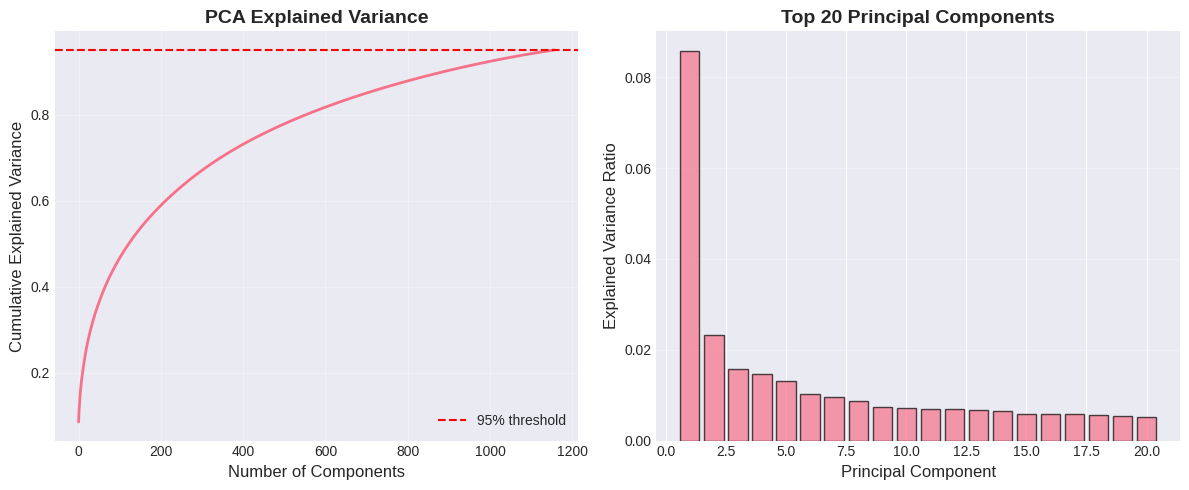

In [22]:
print("\nStandardizing features...")
scaler = StandardScaler()
features_scaled = scaler.fit_transform(all_features)

# Apply PCA
print("\nApplying PCA...")
pca = PCA(n_components=0.95, random_state=42)
features_pca = pca.fit_transform(features_scaled)

print(f"Original dimensions: {features_scaled.shape[1]}")
print(f"PCA dimensions: {features_pca.shape[1]}")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.4f}")

# Visualize explained variance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('PCA Explained Variance', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(1, min(21, len(pca.explained_variance_ratio_)+1)),
        pca.explained_variance_ratio_[:20], alpha=0.7, edgecolor='black')
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.title('Top 20 Principal Components', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('03_pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## FIND OPTIMAL NUMBER OF CLUSTERS


Evaluating different values of K...
Testing K=5... Silhouette=0.028
Testing K=6... Silhouette=0.029
Testing K=7... Silhouette=0.011
Testing K=8... Silhouette=0.009
Testing K=9... Silhouette=0.009
Testing K=10... Silhouette=0.005
Testing K=11... Silhouette=0.006
Testing K=12... Silhouette=0.000
Testing K=13... Silhouette=-0.008
Testing K=14... Silhouette=0.001
Testing K=15... Silhouette=-0.009
Testing K=16... Silhouette=-0.009
Testing K=17... Silhouette=-0.010
Testing K=18... Silhouette=-0.011
Testing K=19... Silhouette=-0.010
Testing K=20... Silhouette=-0.007

CLUSTERING EVALUATION METRICS
 k      inertia  silhouette  davies_bouldin  calinski_harabasz
 5 5.779793e+07    0.027689        5.517548         411.545125
 6 5.743587e+07    0.029443        5.502510         350.192783
 7 5.709241e+07    0.010529        5.723192         308.596102
 8 5.683150e+07    0.009333        5.782014         275.540045
 9 5.660470e+07    0.009117        5.628390         249.555376
10 5.641149e+07    0.005

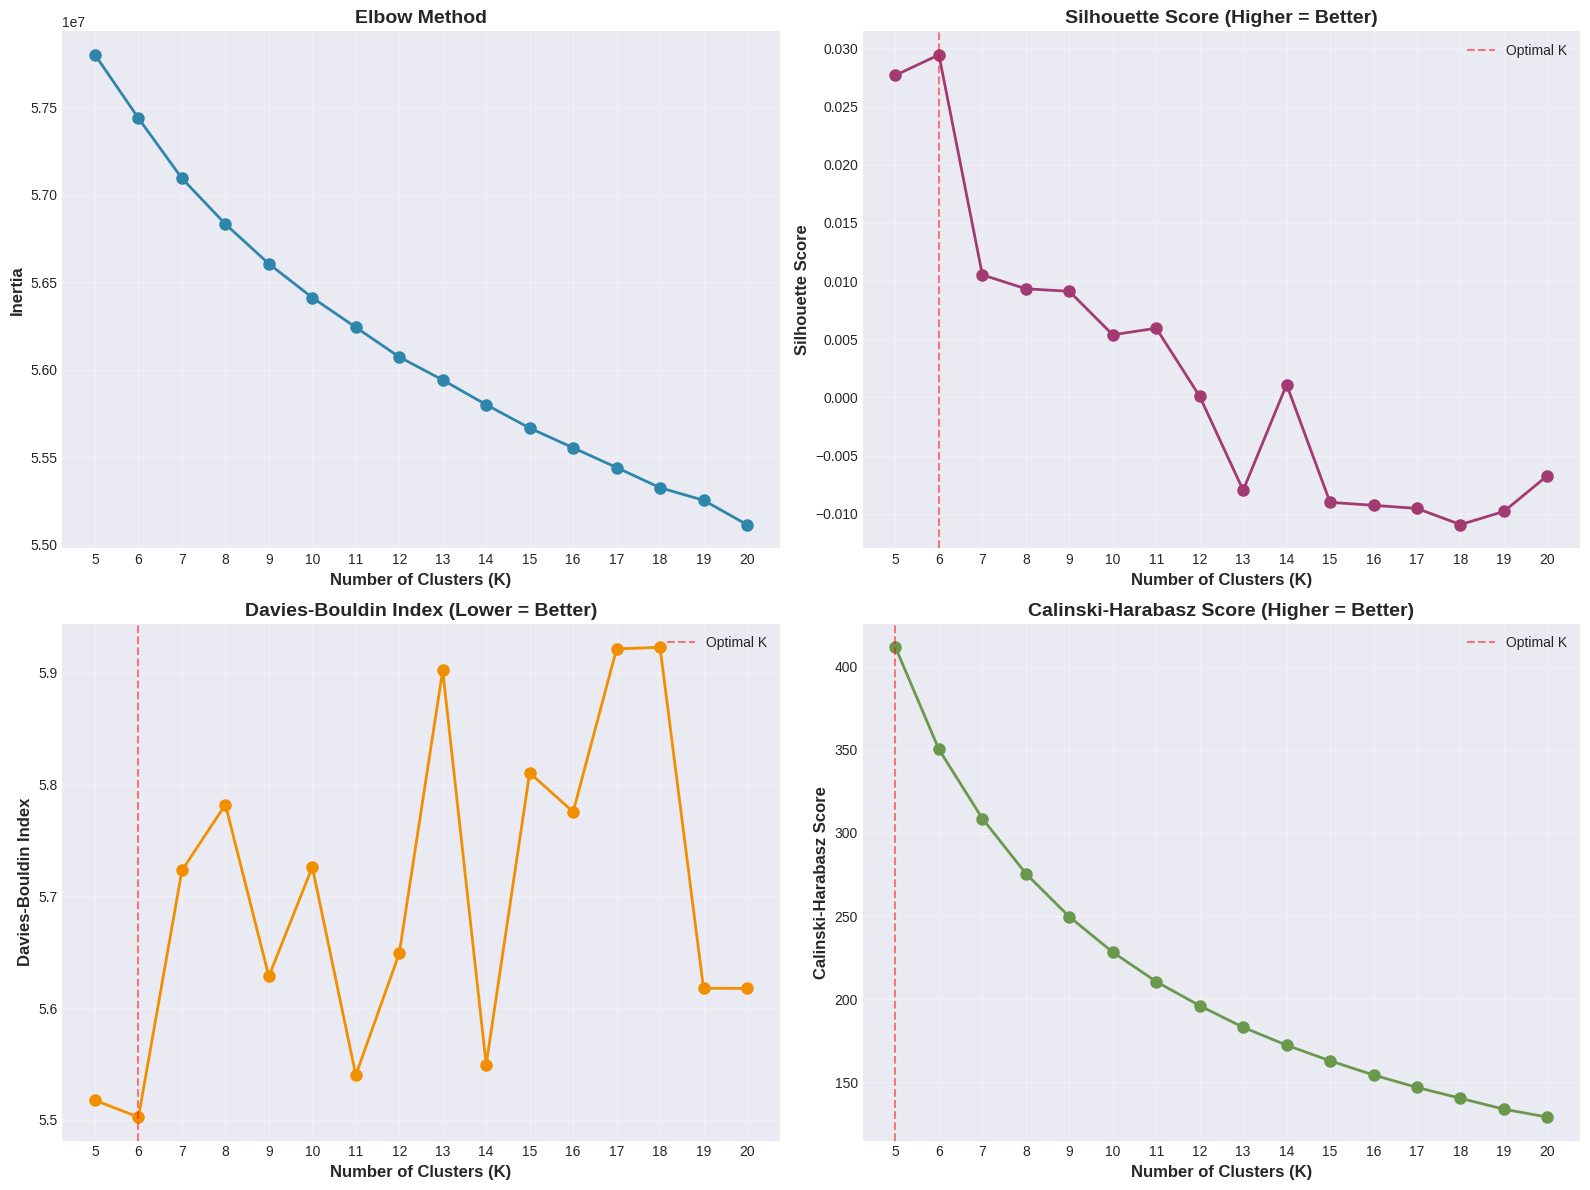


🎯 OPTIMAL K = 6 (based on highest Silhouette Score)


In [25]:
k_range = range(5, 21)
results = {'k': [], 'inertia': [], 'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []}

print("\nEvaluating different values of K...")
for k in k_range:
    print(f"Testing K={k}...", end=' ')
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(features_pca)

    results['k'].append(k)
    results['inertia'].append(kmeans.inertia_)
    results['silhouette'].append(silhouette_score(features_pca, labels))
    results['davies_bouldin'].append(davies_bouldin_score(features_pca, labels))
    results['calinski_harabasz'].append(calinski_harabasz_score(features_pca, labels))

    print(f"Silhouette={results['silhouette'][-1]:.3f}")

cluster_metrics = pd.DataFrame(results)

print("\n" + "="*80)
print("CLUSTERING EVALUATION METRICS")
print("="*80)
print(cluster_metrics.to_string(index=False))

# Plot all metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].plot(cluster_metrics['k'], cluster_metrics['inertia'], 'o-', linewidth=2, markersize=8, color='#2E86AB')
axes[0, 0].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Inertia', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(cluster_metrics['k'])

axes[0, 1].plot(cluster_metrics['k'], cluster_metrics['silhouette'], 'o-', linewidth=2, markersize=8, color='#A23B72')
axes[0, 1].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Silhouette Score (Higher = Better)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(cluster_metrics['k'])
best_sil_idx = cluster_metrics['silhouette'].idxmax()
axes[0, 1].axvline(x=cluster_metrics.loc[best_sil_idx, 'k'], color='red', linestyle='--', alpha=0.5, label='Optimal K')
axes[0, 1].legend()

axes[1, 0].plot(cluster_metrics['k'], cluster_metrics['davies_bouldin'], 'o-', linewidth=2, markersize=8, color='#F18F01')
axes[1, 0].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Davies-Bouldin Index (Lower = Better)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(cluster_metrics['k'])
best_db_idx = cluster_metrics['davies_bouldin'].idxmin()
axes[1, 0].axvline(x=cluster_metrics.loc[best_db_idx, 'k'], color='red', linestyle='--', alpha=0.5, label='Optimal K')
axes[1, 0].legend()

axes[1, 1].plot(cluster_metrics['k'], cluster_metrics['calinski_harabasz'], 'o-', linewidth=2, markersize=8, color='#6A994E')
axes[1, 1].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Calinski-Harabasz Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Calinski-Harabasz Score (Higher = Better)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(cluster_metrics['k'])
best_ch_idx = cluster_metrics['calinski_harabasz'].idxmax()
axes[1, 1].axvline(x=cluster_metrics.loc[best_ch_idx, 'k'], color='red', linestyle='--', alpha=0.5, label='Optimal K')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('04_optimal_k_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

optimal_k = int(cluster_metrics.loc[cluster_metrics['silhouette'].idxmax(), 'k'])
print(f"\n🎯 OPTIMAL K = {optimal_k} (based on highest Silhouette Score)")

## APPLY MULTIPLE CLUSTERING ALGORITHMS

In [26]:
# K-Means
print(f"\n[1] K-Means Clustering (K={optimal_k})...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=500)
labels_kmeans = kmeans.fit_predict(features_pca)
silhouette_kmeans = silhouette_score(features_pca, labels_kmeans)
print(f"    Silhouette Score: {silhouette_kmeans:.4f}")
print(f"    Cluster sizes: {np.bincount(labels_kmeans)}")

# Hierarchical
print(f"\n[2] Hierarchical Clustering (K={optimal_k})...")
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
labels_hierarchical = hierarchical.fit_predict(features_pca)
silhouette_hierarchical = silhouette_score(features_pca, labels_hierarchical)
print(f"    Silhouette Score: {silhouette_hierarchical:.4f}")
print(f"    Cluster sizes: {np.bincount(labels_hierarchical)}")

# Gaussian Mixture
print(f"\n[3] Gaussian Mixture Model (K={optimal_k})...")
gmm = GaussianMixture(n_components=optimal_k, random_state=42, n_init=10)
labels_gmm = gmm.fit_predict(features_pca)
silhouette_gmm = silhouette_score(features_pca, labels_gmm)
print(f"    Silhouette Score: {silhouette_gmm:.4f}")
print(f"    Cluster sizes: {np.bincount(labels_gmm)}")

# DBSCAN
print(f"\n[4] DBSCAN Clustering...")
dbscan = DBSCAN(eps=3.5, min_samples=10)
labels_dbscan = dbscan.fit_predict(features_pca)
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)
print(f"    Clusters found: {n_clusters_dbscan}")
print(f"    Noise points: {n_noise}")
if n_clusters_dbscan > 1 and n_noise < len(labels_dbscan):
    mask_valid = labels_dbscan != -1
    silhouette_dbscan = silhouette_score(features_pca[mask_valid], labels_dbscan[mask_valid])
    print(f"    Silhouette Score: {silhouette_dbscan:.4f}")
else:
    silhouette_dbscan = 0

# Compare algorithms
print("\n" + "="*80)
print("ALGORITHM COMPARISON")
print("="*80)
comparison = pd.DataFrame({
    'Algorithm': ['K-Means', 'Hierarchical', 'Gaussian Mixture', 'DBSCAN'],
    'Silhouette Score': [silhouette_kmeans, silhouette_hierarchical, silhouette_gmm, silhouette_dbscan],
    'N Clusters': [optimal_k, optimal_k, optimal_k, n_clusters_dbscan]
})
print(comparison.to_string(index=False))

best_algo_idx = comparison['Silhouette Score'].idxmax()
best_algorithm = comparison.loc[best_algo_idx, 'Algorithm']
print(f"\n🏆 Best Algorithm: {best_algorithm}")

if best_algorithm == 'K-Means':
    final_labels = labels_kmeans
elif best_algorithm == 'Hierarchical':
    final_labels = labels_hierarchical
elif best_algorithm == 'Gaussian Mixture':
    final_labels = labels_gmm
else:
    final_labels = labels_dbscan
    optimal_k = n_clusters_dbscan


[1] K-Means Clustering (K=6)...
    Silhouette Score: 0.0294
    Cluster sizes: [6221 1364 1152 1777 2483 2003]

[2] Hierarchical Clustering (K=6)...
    Silhouette Score: 0.0409
    Cluster sizes: [9106 1589 1948 1241  553  563]

[3] Gaussian Mixture Model (K=6)...
    Silhouette Score: 0.0294
    Cluster sizes: [6221 1364 1152 1777 2483 2003]

[4] DBSCAN Clustering...
    Clusters found: 0
    Noise points: 15000

ALGORITHM COMPARISON
       Algorithm  Silhouette Score  N Clusters
         K-Means          0.029443           6
    Hierarchical          0.040926           6
Gaussian Mixture          0.029443           6
          DBSCAN          0.000000           0

🏆 Best Algorithm: Hierarchical


## 2D VISUALIZATION


Computing t-SNE (this may take a few minutes)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.075s...
[t-SNE] Computed neighbors for 15000 samples in 22.681s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000

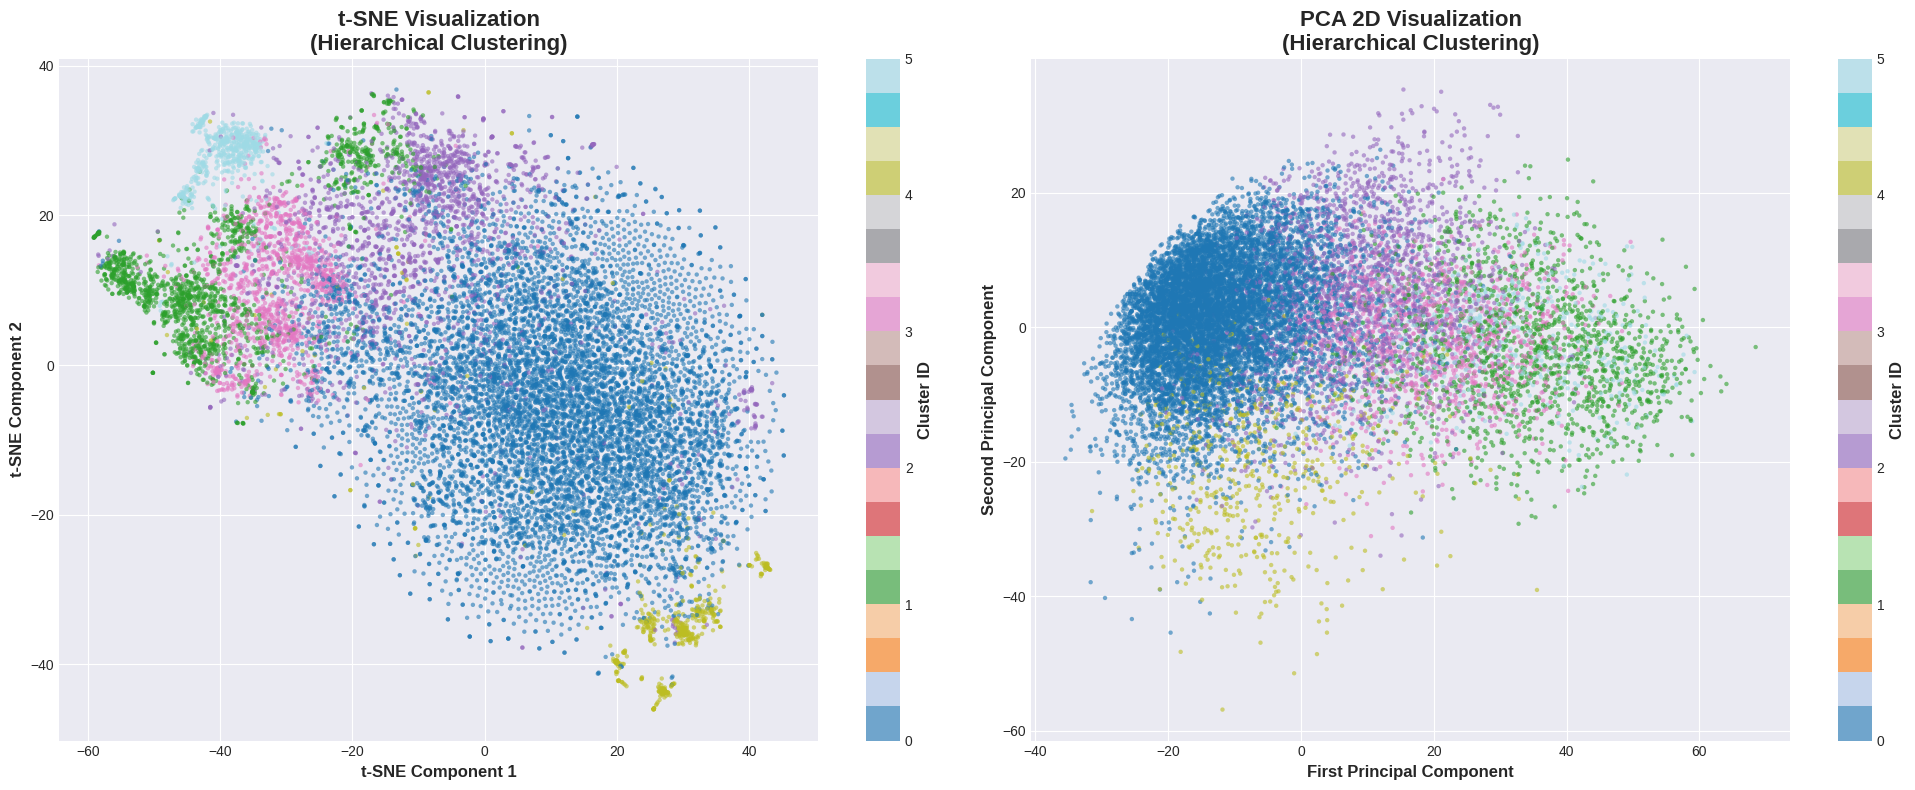

In [27]:
# t-SNE
print("\nComputing t-SNE (this may take a few minutes)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)
features_tsne = tsne.fit_transform(features_pca)

# PCA 2D
print("\nComputing 2D PCA...")
pca_2d = PCA(n_components=2, random_state=42)
features_pca_2d = pca_2d.fit_transform(features_pca)
print(f"2D PCA explained variance: {pca_2d.explained_variance_ratio_.sum():.4f}")

# Plot both
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

scatter1 = axes[0].scatter(features_tsne[:, 0], features_tsne[:, 1], c=final_labels, cmap='tab20', alpha=0.6, s=10, edgecolors='none')
axes[0].set_title(f't-SNE Visualization\n({best_algorithm} Clustering)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1', fontsize=12, fontweight='bold')
axes[0].set_ylabel('t-SNE Component 2', fontsize=12, fontweight='bold')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster ID', fontsize=12, fontweight='bold')

scatter2 = axes[1].scatter(features_pca_2d[:, 0], features_pca_2d[:, 1], c=final_labels, cmap='tab20', alpha=0.6, s=10, edgecolors='none')
axes[1].set_title(f'PCA 2D Visualization\n({best_algorithm} Clustering)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('First Principal Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Second Principal Component', fontsize=12, fontweight='bold')
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Cluster ID', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('05_2d_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

## VISUALIZE CLUSTER SAMPLES

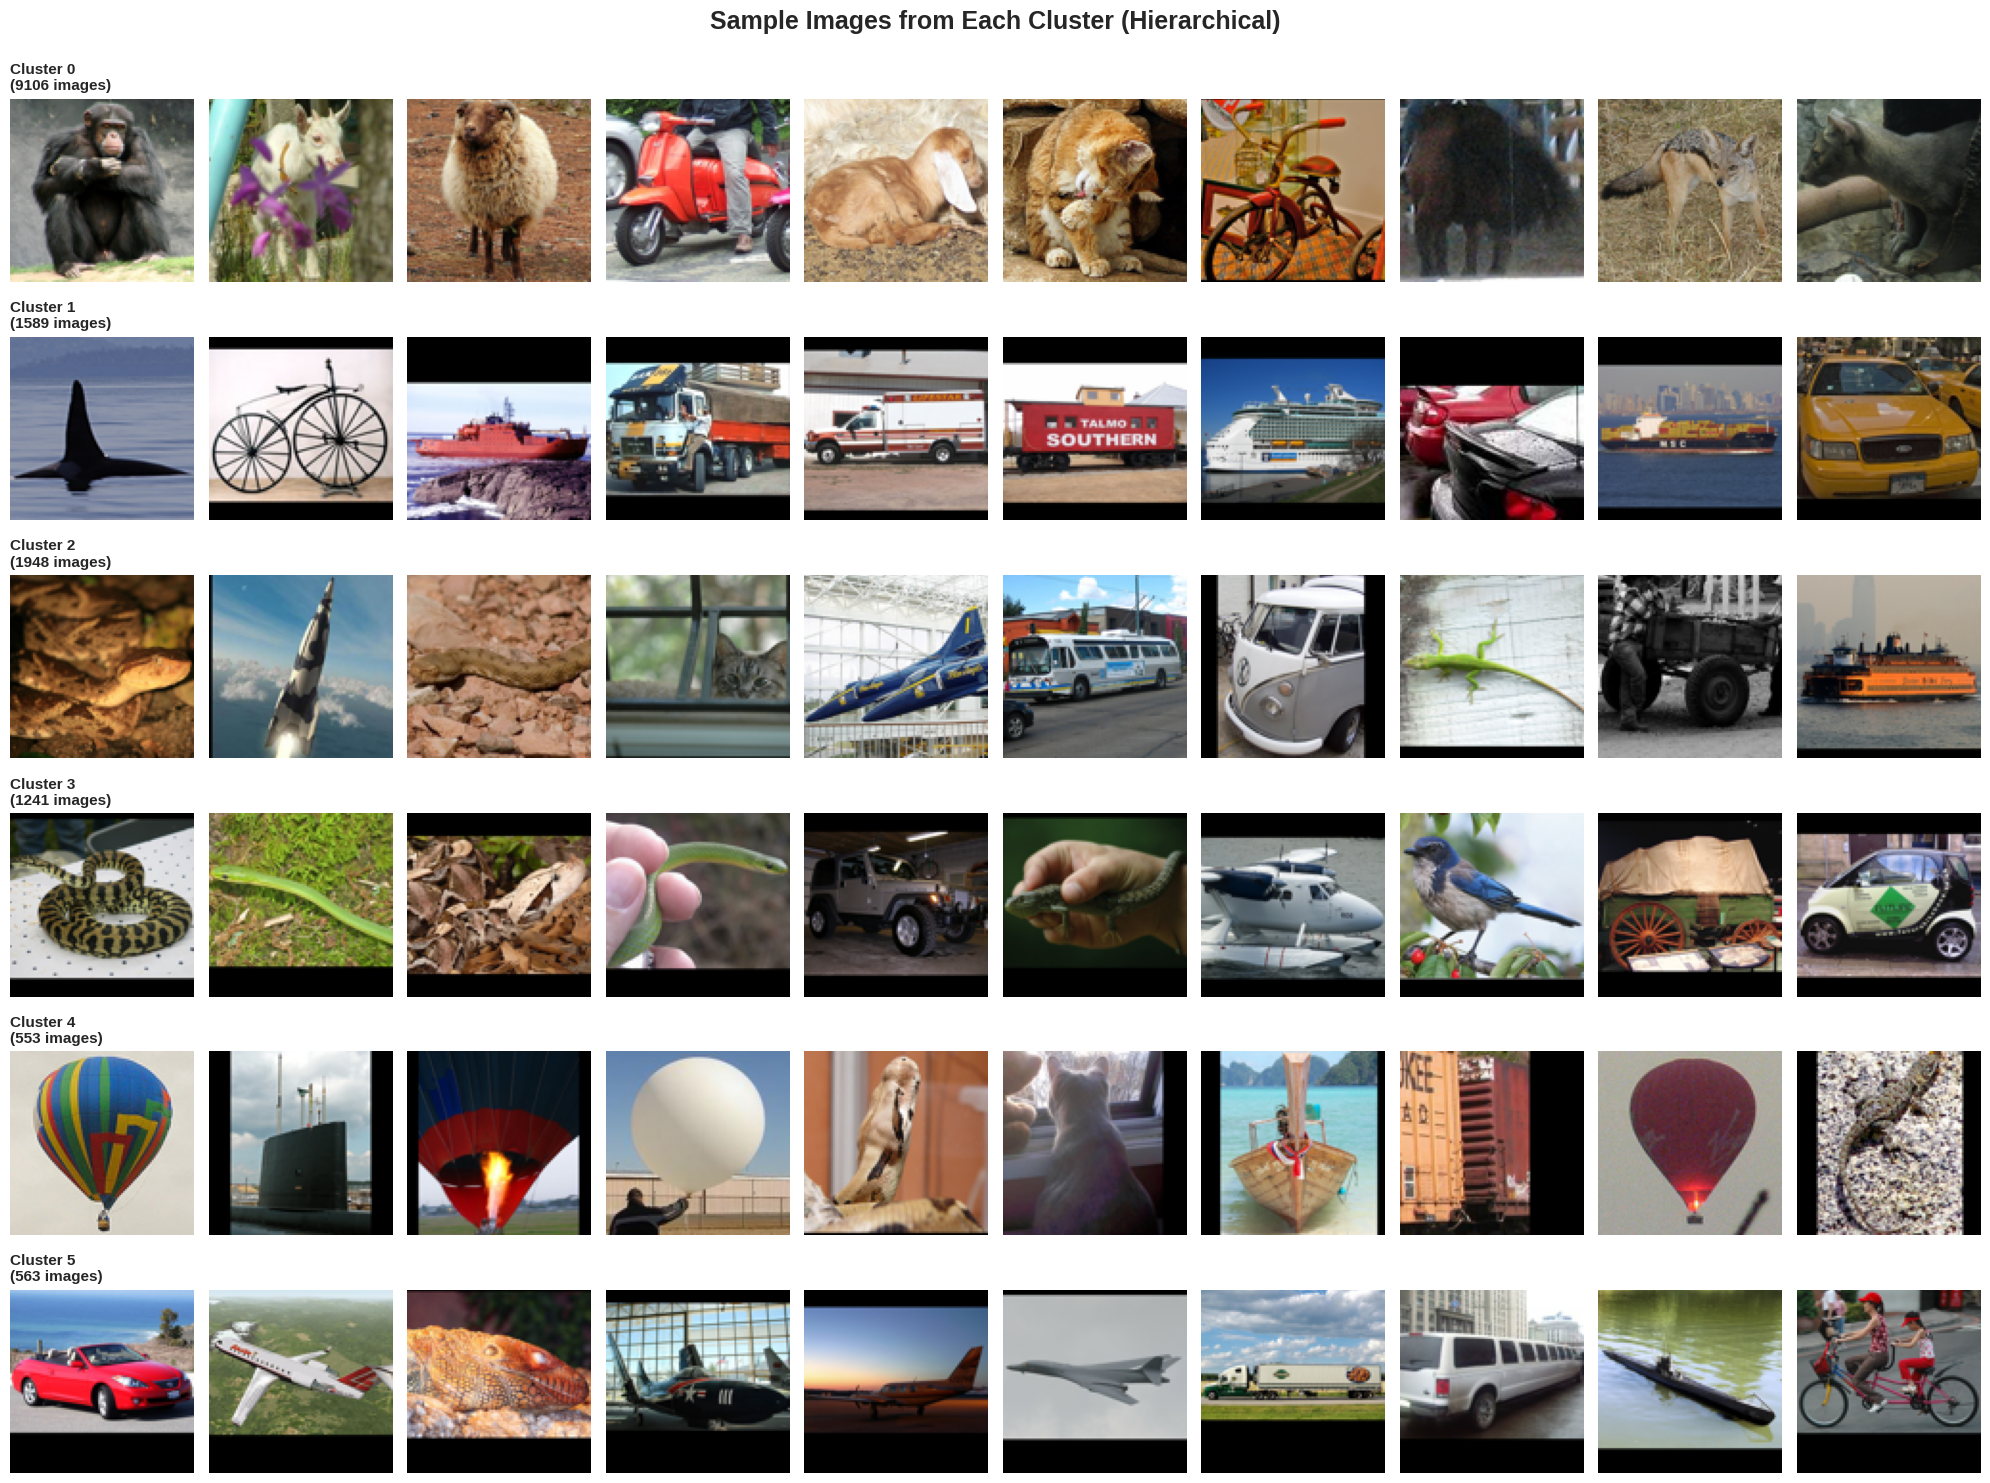

In [28]:
samples_per_cluster = 10
fig, axes = plt.subplots(optimal_k, samples_per_cluster, figsize=(20, 2.5*optimal_k))

if optimal_k == 1:
    axes = axes.reshape(1, -1)

for cluster_id in range(optimal_k):
    cluster_mask = final_labels == cluster_id
    cluster_indices = np.where(cluster_mask)[0]

    if len(cluster_indices) == 0:
        continue

    n_samples_in_cluster = len(cluster_indices)

    if n_samples_in_cluster >= samples_per_cluster:
        sample_idx = np.random.choice(cluster_indices, samples_per_cluster, replace=False)
    else:
        sample_idx = cluster_indices

    for i in range(samples_per_cluster):
        if i < len(sample_idx):
            axes[cluster_id, i].imshow(images[sample_idx[i]])
            axes[cluster_id, i].axis('off')
            if i == 0:
                axes[cluster_id, i].set_title(f'Cluster {cluster_id}\n({n_samples_in_cluster} images)',
                                             fontsize=11, fontweight='bold', loc='left')
        else:
            axes[cluster_id, i].axis('off')

plt.suptitle(f'Sample Images from Each Cluster ({best_algorithm})', fontsize=18, fontweight='bold', y=0.998)
plt.tight_layout()
plt.savefig('06_cluster_samples.png', dpi=300, bbox_inches='tight')
plt.show()

 ## CLUSTER CHARACTERISTICS ANALYSIS


Cluster Statistics:
 Cluster  Size  Avg_Brightness  Std_Brightness    Avg_Red  Avg_Green   Avg_Blue  Color_Variance
       0  9106      108.376334       62.676089 117.206632 111.752368  96.170001       62.029104
       1  1589      107.003704       79.337118 104.279206 107.618934 109.112974       79.273481
       2  1948      115.006108       69.202812 114.541956 116.108404 114.367965       69.173877
       3  1241       90.388100       72.953918  95.774208  91.773478  83.616615       72.766450
       4   553      104.289680       82.496347 108.481066 104.759996  99.627977       82.409066
       5   563       86.600526       76.508434  88.206266  87.619148  83.976163       76.481127


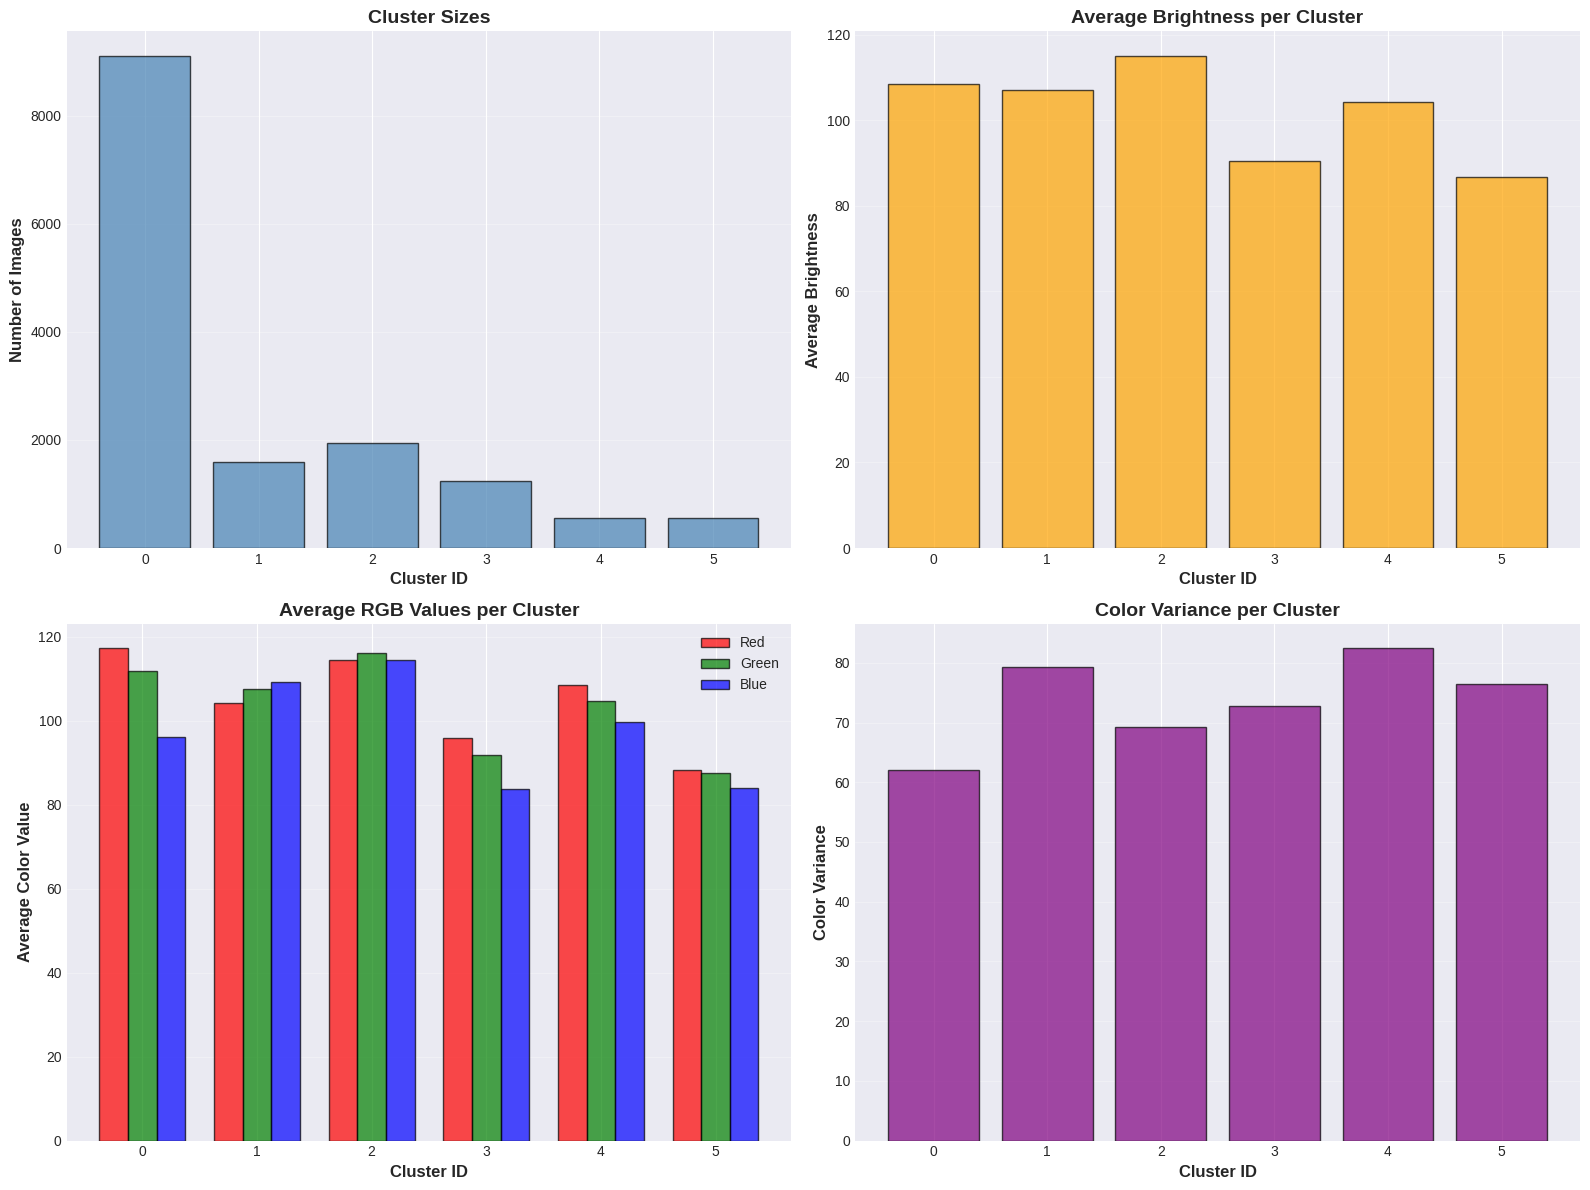

In [29]:
characteristics = []
for cluster_id in range(optimal_k):
    cluster_mask = final_labels == cluster_id
    cluster_images = images[cluster_mask]

    if len(cluster_images) == 0:
        continue

    avg_brightness = cluster_images.mean()
    std_brightness = cluster_images.std()
    avg_red = cluster_images[:, :, :, 0].mean()
    avg_green = cluster_images[:, :, :, 1].mean()
    avg_blue = cluster_images[:, :, :, 2].mean()
    color_variance = cluster_images.std(axis=(0, 1, 2)).mean()

    characteristics.append({
        'Cluster': cluster_id,
        'Size': cluster_mask.sum(),
        'Avg_Brightness': avg_brightness,
        'Std_Brightness': std_brightness,
        'Avg_Red': avg_red,
        'Avg_Green': avg_green,
        'Avg_Blue': avg_blue,
        'Color_Variance': color_variance
    })

cluster_stats = pd.DataFrame(characteristics)
print("\nCluster Statistics:")
print(cluster_stats.to_string(index=False))

# Visualize cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].bar(cluster_stats['Cluster'], cluster_stats['Size'], color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Cluster ID', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Images', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Cluster Sizes', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

axes[0, 1].bar(cluster_stats['Cluster'], cluster_stats['Avg_Brightness'], color='orange', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Cluster ID', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Average Brightness', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Average Brightness per Cluster', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

x = np.arange(len(cluster_stats))
width = 0.25
axes[1, 0].bar(x - width, cluster_stats['Avg_Red'], width, label='Red', color='red', alpha=0.7, edgecolor='black')
axes[1, 0].bar(x, cluster_stats['Avg_Green'], width, label='Green', color='green', alpha=0.7, edgecolor='black')
axes[1, 0].bar(x + width, cluster_stats['Avg_Blue'], width, label='Blue', color='blue', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Cluster ID', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Average Color Value', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Average RGB Values per Cluster', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(cluster_stats['Cluster'])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

axes[1, 1].bar(cluster_stats['Cluster'], cluster_stats['Color_Variance'], color='purple', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Cluster ID', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Color Variance', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Color Variance per Cluster', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('07_cluster_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

## CLUSTER INTERPRETATION

In [32]:
for _, row in cluster_stats.iterrows():
    cluster_id = int(row['Cluster'])
    brightness = row['Avg_Brightness']
    red = row['Avg_Red']
    green = row['Avg_Green']
    blue = row['Avg_Blue']

    rgb = [red, green, blue]
    colors = ['Red', 'Green', 'Blue']
    dominant_color = colors[np.argmax(rgb)]

    if brightness < 85:
        brightness_cat = "Dark"
    elif brightness < 170:
        brightness_cat = "Medium"
    else:
        brightness_cat = "Bright"

    interpretation = f"{brightness_cat} images with {dominant_color}-ish tones"

    print(f"\nCluster {cluster_id} ({int(row['Size'])} images):")
    print(f"  - {interpretation}")
    print(f"  - Brightness: {brightness:.1f}/255")
    print(f"  - RGB: R={red:.1f}, G={green:.1f}, B={blue:.1f}")


Cluster 0 (9106 images):
  - Medium images with Red-ish tones
  - Brightness: 108.4/255
  - RGB: R=117.2, G=111.8, B=96.2

Cluster 1 (1589 images):
  - Medium images with Blue-ish tones
  - Brightness: 107.0/255
  - RGB: R=104.3, G=107.6, B=109.1

Cluster 2 (1948 images):
  - Medium images with Green-ish tones
  - Brightness: 115.0/255
  - RGB: R=114.5, G=116.1, B=114.4

Cluster 3 (1241 images):
  - Medium images with Red-ish tones
  - Brightness: 90.4/255
  - RGB: R=95.8, G=91.8, B=83.6

Cluster 4 (553 images):
  - Medium images with Red-ish tones
  - Brightness: 104.3/255
  - RGB: R=108.5, G=104.8, B=99.6

Cluster 5 (563 images):
  - Medium images with Red-ish tones
  - Brightness: 86.6/255
  - RGB: R=88.2, G=87.6, B=84.0


## FINAL SUMMARY

In [34]:
summary = f"""
PROJECT: Discovering Image Clusters in STL-10 Dataset
METHOD: Unsupervised Machine Learning

DATASET INFORMATION:
  • Total images analyzed: {len(images):,}
  • Image dimensions: {images.shape[1]}×{images.shape[2]}×{images.shape[3]}

FEATURE EXTRACTION:
  • Color Histograms (RGB, 32 bins)
  • HOG (Histogram of Oriented Gradients)
  • Statistical Features
  • Texture Features (LBP)
  • Total features: {all_features.shape[1]:,} dimensions

DIMENSIONALITY REDUCTION:
  • Method: PCA
  • Reduced to: {features_pca.shape[1]} components
  • Variance explained: {pca.explained_variance_ratio_.sum():.2%}

CLUSTERING:
  • Best Algorithm: {best_algorithm}
  • Optimal clusters: {optimal_k}
  • Silhouette Score: {comparison.loc[best_algo_idx, 'Silhouette Score']:.4f}

VISUALIZATION:
  • 2D projections: t-SNE and PCA
  • Cluster sample grids
  • Statistical analysis charts

✅ PROJECT COMPLETE!
"""

print(summary)

with open('project_summary.txt', 'w') as f:
    f.write(summary)
    f.write("\n\nCLUSTER STATISTICS:\n")
    f.write(cluster_stats.to_string(index=False))

print("\n✅ Summary saved to 'project_summary.txt'")
print("✅ All visualizations saved")
print("\n" + "="*80)
print("🎉 UNSUPERVISED LEARNING PROJECT COMPLETED SUCCESSFULLY! 🎉")
print("="*80)


PROJECT: Discovering Image Clusters in STL-10 Dataset
METHOD: Unsupervised Machine Learning

DATASET INFORMATION:
  • Total images analyzed: 15,000
  • Image dimensions: 96×96×3

FEATURE EXTRACTION:
  • Color Histograms (RGB, 32 bins)
  • HOG (Histogram of Oriented Gradients)
  • Statistical Features
  • Texture Features (LBP)
  • Total features: 4,501 dimensions

DIMENSIONALITY REDUCTION:
  • Method: PCA
  • Reduced to: 1158 components
  • Variance explained: 95.01%

CLUSTERING:
  • Best Algorithm: Hierarchical
  • Optimal clusters: 6
  • Silhouette Score: 0.0409

VISUALIZATION:
  • 2D projections: t-SNE and PCA
  • Cluster sample grids
  • Statistical analysis charts

✅ PROJECT COMPLETE!


✅ Summary saved to 'project_summary.txt'
✅ All visualizations saved

🎉 UNSUPERVISED LEARNING PROJECT COMPLETED SUCCESSFULLY! 🎉
